In [1]:
import pandas as pd
import numpy as np
import rasterio as rio
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from matplotlib.lines import Line2D 
from matplotlib.offsetbox import AnchoredText
import geopandas as gpd
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
import glob
from matplotlib.ticker import FuncFormatter

## Load sample points that overlap ours and macander's rasters

In [2]:
# load sample points
path = 'mac17_sample_points'
points = gpd.read_file(f'{path}/macander_sample_points.shp')
points['x'] = points.geometry.x
points['y'] = points.geometry.y
coords = [(x,y) for x, y in zip(points.x, points.y)]

## Load Macander data clipped to PAVC Gridded data and water masked

In [3]:
# load macander data
macdir = 'mac17_water-masked_pavc-clipped'
mac_tifs = sorted(glob.glob(f'{macdir}/*_01.tif'))

mac_rasters = []
for tif in mac_tifs:
    rast = rxr.open_rasterio(tif, masked=True)
    mac_rasters.append(rast)

## Load PAVC Gridded data clipped to Macander data and water masked

In [4]:
# load our data
pavcdir = 'pavc-g_water-masked_mac-clipped'
pavc_tifs = sorted(glob.glob(f'{pavcdir}/*_masked_macclip.tif'))

pavc_rasters = []
for tif in pavc_tifs:
    rast = rxr.open_rasterio(tif, masked=True)
    pavc_rasters.append(rast)

## Create class for handling seaborn grid details

In [5]:
class sfg():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

# extra definition
def share_axes(axes, xlab, labs, sharex=True, sharey=False):
    if isinstance(axes, np.ndarray):
        axes = axes.flat  # from plt.subplots
    elif isinstance(axes, dict):
        axes = list(axes.values())  # from plt.subplot_mosaic
    else:
        axes = list(axes)
    ax0 = axes[0]
    for ax in axes:
        if sharex:
            ax.sharex(ax0)
            if not ax.get_subplotspec().is_last_row():
                ax.tick_params(labelbottom=False)
                continue
            ax.set_xlabel(xlab, fontsize=14)
        if sharey:
            ax.sharey(ax0)
            if not ax.get_subplotspec().is_first_col():
                ax.tick_params(labelleft=False) 

In [6]:
def calculate_regression(pred, test):
    # calculate regression stats
    flag = np.logical_and(~np.isnan(pred), ~np.isnan(test))
    pred = pred[flag]
    test = test[flag]
    
    # calculate R-squared value
    res = stats.linregress(pred,test)
    r_squared = res.rvalue**2
    mse = mean_squared_error(pred,test)
    rmse = mse ** 0.5
    mae = mean_absolute_error(pred,test)

    return r_squared, rmse, mae

## Start plotting

In [7]:
pfts = [tif.split('/')[-1].split('_masked_mac_01.tif')[0] for tif in mac_tifs]
pfts

['bryophyte',
 'deciduous_shrub',
 'evergreen_shrub',
 'forb',
 'graminoid',
 'lichen',
 'litter',
 'non-vascular']

In [8]:
# set plotting order
pft_order = [
    "deciduous_shrub", "evergreen_shrub", "forb", "graminoid",
    "litter", "non-vascular", "bryophyte", "lichen"
]

# create a dictionary to pair PFTs with their respective rasters
pft_dict = {pft: (mac_raster, pavc_raster) for pft, mac_raster, pavc_raster in zip(pfts, mac_rasters, pavc_rasters)}

# reorder based on the predefined PFT order
sorted_pfts = [pft for pft in pft_order if pft in pft_dict]  # Ensure only existing PFTs are included
sorted_mac_rasters = [pft_dict[pft][0] for pft in sorted_pfts]
sorted_pavc_rasters = [pft_dict[pft][1] for pft in sorted_pfts]

# update the original lists
pfts = sorted_pfts
mac_rasters = sorted_mac_rasters
pavc_rasters = sorted_pavc_rasters

In [9]:
import pandas as pd

# Create a list to store data
all_data = []

# Loop through PFTs and rasters, storing data in a list
for mac_raster, pavc_raster, pft in zip(mac_rasters, pavc_rasters, pfts):

    print(pft)

    # create xarray data arrays of points shapefile geometry
    da_x = xr.DataArray(points.geometry.x.values, dims=['z'])
    da_y = xr.DataArray(points.geometry.y.values, dims=['z'])
    
    # Sample rasters
    mac_results = mac_raster.sel(x=da_x, y=da_y, method='nearest')
    pavc_results = pavc_raster.sel(x=da_x, y=da_y, method='nearest')

    # Flatten into 1D arrays
    mac_arr = mac_results.to_dataset(name='temp').to_array().values.ravel()
    pavc_arr = pavc_results.to_dataset(name='temp').to_array().values.ravel()

    # Create a DataFrame for this PFT
    df = pd.DataFrame({
        'Macander 2017 Cover': mac_arr / 100,  # Normalize if needed
        'PAVC-Gridded Cover': pavc_arr,
        'PFT': pft  # Add PFT label for faceting
    })
    
    # Drop NaN values
    df = df.dropna()
    
    # Append to the list
    all_data.append(df)

# Concatenate into a single DataFrame
df_combined = pd.concat(all_data, ignore_index=True)

deciduous_shrub
evergreen_shrub
forb
graminoid
litter
non-vascular
bryophyte
lichen


In [10]:
df_combined

,Macander 2017 Cover,PAVC-Gridded Cover,PFT
0,0.24,0.356503,deciduous_shrub
1,0.31,0.247498,deciduous_shrub
2,0.25,0.316907,deciduous_shrub
3,0.26,0.289280,deciduous_shrub
4,0.30,0.370158,deciduous_shrub
...,...,...,...
20289,0.11,0.082027,lichen
20290,0.10,0.073819,lichen
20291,0.12,0.099599,lichen
20292,0.14,0.084447,lichen


Working on axis 0 deciduous_shrub...
Working on axis 1 evergreen_shrub...
Working on axis 2 forb...
Working on axis 3 graminoid...
Working on axis 4 litter...
Working on axis 5 non-vascular...
Working on axis 6 bryophyte...
Working on axis 7 lichen...


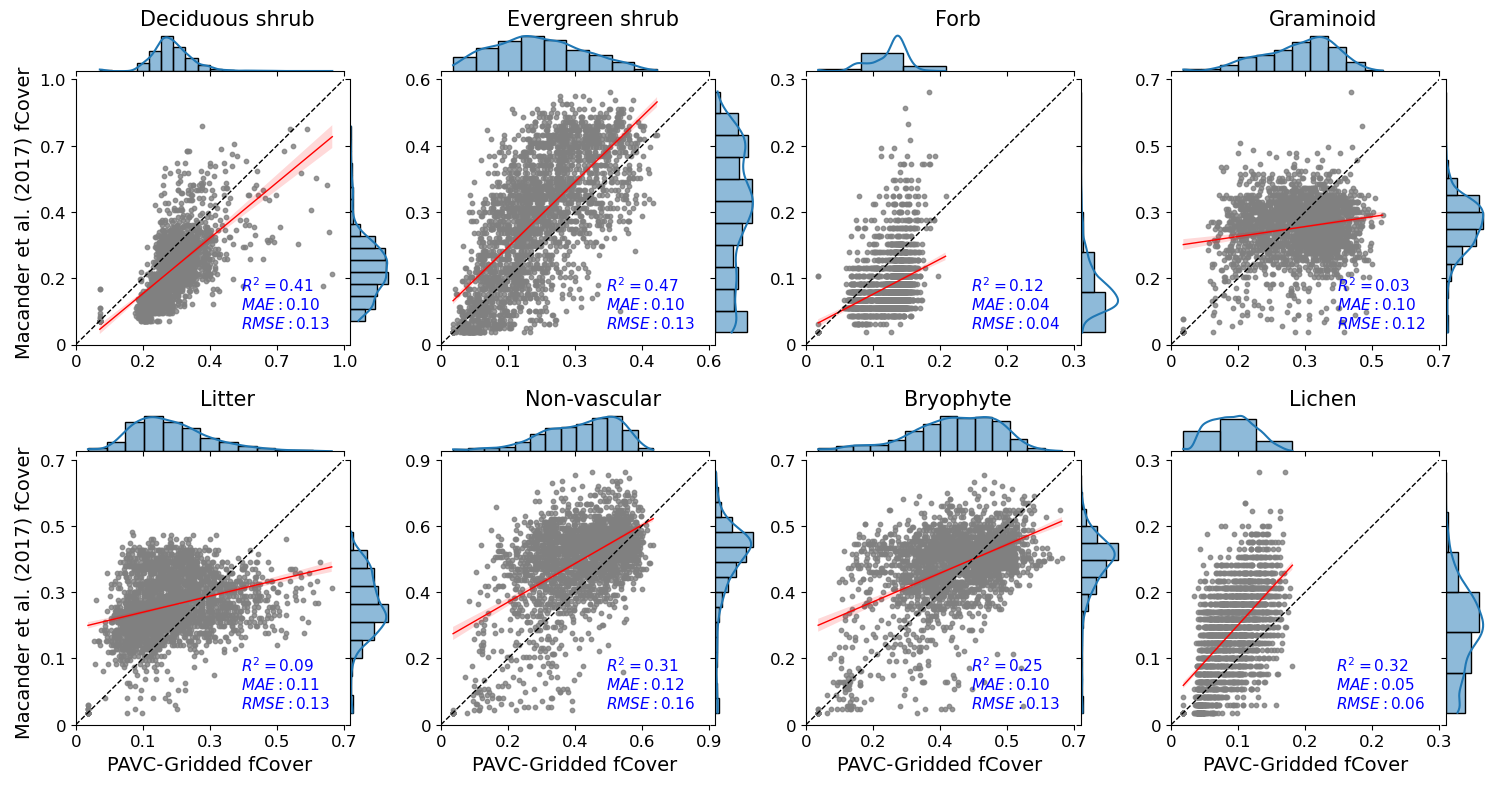

In [11]:
# initiate figure and grid
fig = plt.figure(figsize=(15,8))
rows, cols = 2, 4
gs = gridspec.GridSpec(rows, cols)
idxs = []
for i, g in enumerate(gs):
    idxs.append(i)

# set axis labels
xlab = None #'fCover (this study)'
axs = []
for i in range(rows):
    for j in range(cols):
        ax = plt.subplot(gs[i, j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        axs.append(ax)
share_axes(axs, xlab, pfts)

for pft, idx in zip(pfts, idxs):

    print(f'Working on axis {idx} {pft}...')

    df_pft = df_combined[df_combined['PFT'] == pft]

    # get regression line
    r_squared, rmse, mae = calculate_regression(pred=df_pft['PAVC-Gridded Cover'], test=df_pft['Macander 2017 Cover'])

    # prep for graphing
    df_pft = df_pft.dropna(how='any')
    linedf = pd.DataFrame([[0,1], [0,1]], columns=['x', 'y']) # 1:1 line

    # plot
    g = sns.jointplot(data=df_pft, x='PAVC-Gridded Cover', y='Macander 2017 Cover',
                      kind='reg', scatter_kws={'s':10, 'color':'grey'}, 
                      line_kws=dict(color='red', linewidth=1),
                      marginal_kws=dict(binwidth=0.05))
    
    # set y-axis bins manually since marginal_kws only applies to x-axis by default
    # g.ax_marg_y.hist(df_pft['Macander 2017 Cover'], bins=10, color='grey', edgecolor='black')

    g.ax_joint.set_xlabel(None)
    g.ax_joint.set_ylabel(None)

    # Get the current limits
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()

    # Compute a common range that covers both axes
    lim_low = min(x0, y0)
    lim_high = max(x1, y1)

    # Set both axes to the same limits
    g.ax_joint.set_xlim(lim_low, lim_high)
    g.ax_joint.set_ylim(lim_low, lim_high)

    # Define number of ticks
    num_ticks = 5  

    # Generate evenly spaced tick marks
    ticks = np.linspace(lim_low, lim_high, num_ticks)  # Keep original spacing

    # Apply ticks to both axes (unchanged positions)
    g.ax_joint.set_xticks(ticks)
    g.ax_joint.set_yticks(ticks)

    # Custom formatter: replaces -0.0 with 0 without changing tick locations
    def zero_formatter(x, pos):
        if x < 0:
            return str(0)
        else:
            return f'{x:.1f}'

    # Apply formatter to both axes
    g.ax_joint.xaxis.set_major_formatter(FuncFormatter(zero_formatter))
    g.ax_joint.yaxis.set_major_formatter(FuncFormatter(zero_formatter))
    g.ax_joint.xaxis.set_tick_params(labelsize=12)
    g.ax_joint.yaxis.set_tick_params(labelsize=12)

    # add regression line information
    def textonly(ax, txt, fontsize=11, loc=2, *args, **kwargs):
        at = AnchoredText(txt,
                          prop=dict(size=fontsize, color='blue'), 
                          frameon=False,
                          loc=loc)
        ax.add_artist(at)
    txt = f'$R^2={r_squared:.2f}$\n$MAE: {mae:.2f}$\n$RMSE: {rmse:.2f}$'
    textonly(plt.gca(), txt, loc=4)

    # plot equilibrium line
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, linewidth=1, linestyle='--', color='black')

    sfg(g, fig, gs[idx])

    # set axis labels
    y_idxs = [0,4]
    x_idxs = [4,5,6,7]
    if idx in y_idxs:
        g.ax_joint.set_ylabel('Macander et al. (2017) fCover', fontdict=dict(fontsize=14))
    if idx in x_idxs:
        g.ax_joint.set_xlabel('PAVC-Gridded fCover', fontdict=dict(fontsize=14))

# final show
# gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])
for ax, pft in zip(axs, pfts):
    lab = pft.replace('_', ' ')
    lab = lab.capitalize()
    ax.set_title(lab, pad=10, fontdict=dict(fontsize=15))
plt.tight_layout()
plt.show()